#Definitions

##Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.integrate import quad
from scipy import special
from scipy.optimize import fsolve
from scipy.optimize import minimize

from sympy import symbols, Eq, solve, nsolve, exp, integrate, log, Pow, sqrt, pi, lambdify
from sympy.plotting import plot

from ipywidgets import IntProgress
from IPython.display import display, Latex
import time

import warnings
warnings.filterwarnings("ignore")

##$E_0(\rho)$ and $\kappa_s(\rho)$

In [ ]:
def E_0_y(y):
  """
    Computes the summation in Gallager's E_0 for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result of the summation for a y value, not the complete integral
  """
  suma = 0

  # Sum for all the constellation values  
  for i in range(len(const)):
    suma += probs[i] * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**(1/(1+rho))

  return suma**(rho+1)

In [ ]:
def comp_exponent(x):
  """
    Computes the negative version of the Gallager exponent in order to minimize it
    Arguments:
        x: \rho (float)
    Returns:
        The result of the negative Gallager exponent
  """
  global rho
  
  #Minimize \rho
  rho = x

  #Compute the ingral over y
  E_0_value, err = quad(E_0_y, -np.inf, np.inf)

  #As the exponent is concave, minimize the negative
  return -(-np.log(E_0_value) - rho * rate)

In [ ]:
def E_r(R):
  """
    Computes the Gallager exponent
    Arguments:
        R: Rate (float)
    Returns:
        The result of the Gallager exponent
  """
  global rho, rate

  # Set global variables
  rate = R

  # Minimize the exponent
  res = minimize(comp_exponent, 0.5)

  # \rho must be between 0 and 1 and since for the one-dimensional case bounds
  # cannot be correctly set, it is now done
  if res.x[0] < 0.0:
    res.x[0] = 0.0
  elif res.x[0] > 1.0:
    res.x[0] = 1.0

  # Compute the exponent
  final_res = -comp_exponent(res.x[0])

  return final_res

In [ ]:
def k_prima_s_num(y):
  """
    Computes the summation in the numerator of \kappa_s'(\rho) for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result the summation in the numerator of \kappa_s'(\rho) for a y value
  """
  # Set the optimal s value
  s = 1/(1+rho)

  # Sum in the logarithm numerator
  sum = 0
  for i in range(len(const)):
    sum += probs[i] * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**s

  # Sum the rest of the expression
  sum2 = 0
  for i in range(len(const)):
    w = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)) 

    # Exception control for the logarithm (if not is 0 for this y)
    if not (w <= 0 or sum <= 0 or math.isnan(w) or math.isnan(sum)):
      common = probs[i] * w**(1-s*rho) * sum**rho
      res = common * np.log(sum / w**s)

      # More exception control for extreme y cases
      if not math.isnan(res):
        sum2 += res

  return sum2

In [ ]:
def k_prima_prima_s_num(y):
  """
    Computes the summation in the numerator of \kappa_s''(\rho) for a y value
    Arguments:
        y: Channel output (float)
    Returns:
        The result the summation in the numerator of \kappa_s''(\rho) for a y value
  """
  # Set the optimal s value
  s = 1/(1+rho)

  # Sum in the logarithm numerator
  sum = 0
  for i in range(len(const)):
    sum += probs[i] * (1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)))**s

  # Sum the rest of the expression
  sum2 = 0
  for i in range(len(const)):
    w = 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(y - const[i])**2/(2 * sigma**2)) 

    # Exception control for the logarithm (if not is 0 for this y)
    if not (w <= 0 or sum <= 0 or math.isnan(w) or math.isnan(sum)):
      common = probs[i] * w**(1-s*rho) * sum**rho
      res = common * np.log(sum / w**s)**2

      # More exception control for extreme y cases
      if not math.isnan(res):
        sum2 += res
  
  return sum2

In [ ]:
def solve_k():
  """
    Computes \kappa_s(\rho)
    Returns:
        The result of \kappa_s(\rho)
  """
  # Compute the integral
  res, err = quad(E_0_y, -np.inf, np.inf)

  # Return the logarithm
  return np.log(res)

In [ ]:
def solve_k_prima():
  """
    Computes \kappa_s'(\rho)
    Returns:
        The result of \kappa_s'(\rho)
  """
  #Compute the numerator and denominator
  num, err = quad(k_prima_s_num, -np.inf, np.inf)
  denom = np.exp(solve_k())

  #Exception control (x/0)
  if denom == 0:
    return None

  return num / denom

In [ ]:
def solve_k_prima_prima():
  """
    Computes \kappa_s''(\rho)
    Returns:
        The result of \kappa_s''(\rho)
  """
  #Compute the numerator and denominator
  num, err = quad(k_prima_prima_s_num, -np.inf, np.inf)
  denom = np.exp(solve_k())

  #Exception control (x/0)
  if denom == 0:
    return None

  return num / denom - solve_k_prima()**2

##$RCU_s(n,M)$

In [ ]:
def rcu_over_n():
  """
    Computes the rcu_s(n,M) bound over the n_values range
    Returns:
        The result of rcu_s(n,M) for every n value in the set
  """
  global rho

  # Optimize parameters and compute saddlepoint
  rho_n = minimize(fak, 0.5)
  rho = rho_n.x[0]

  #Compute \kappa(\rho) functions
  k = solve_k()
  k_prima_prima = solve_k_prima_prima()

  #Define the array to store the results
  rcu = []

  #Completion bar
  print("Solving rcu bound over n values:")
  f = IntProgress(min=0, max=len(n_values)) # instantiate the bar
  display(f) # display the bar

  #Compute the bounds
  if rho < 0:
    for n in n_values:
      res = 1 + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)))
      rcu.append(res)
      f.value += 1
  elif 0 < rho < 1:
    for n in n_values:
      res = 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
      rcu.append(res)
      f.value += 1
  else:
    #Compute \kappa_s(1)
    rho_orig = rho
    rho = 1.0
    k1 = solve_k()
    rho = rho_orig
    
    for n in n_values:
      res = np.exp(n * (rate + k1)) + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
      rcu.append(res)
      f.value += 1

  return rcu

In [ ]:
def rcu_over_rate(n, rate_values, rho_values):
  """
    Computes the rcu_s(n,M) bound over the rate_values range
    Arguments:
        n: Sequence length (integer)
        rate_values: Rates (float array)   
        rho_values: \rho for every rate value (float array)    
    Returns:
        The result of rcu_s(n,M) for every rate value in the set
  """
  global rho

  # Define the array to store the results
  rcu = []

  #Completion bar
  print("Solving rcu bound over rate values:")
  f = IntProgress(min=0, max=len(rho_values)) # instantiate the bar
  display(f) # display the bar

  j = 0
  for value in rho_values:
    #Get the parameter and argument values
    rho = value
    rate = rate_values[j]

    #Solve \kappa(\rho) functions
    k = solve_k()
    k_prima_prima = solve_k_prima_prima()

    #Compute the bounds
    if rho < 0:
        res = 1 + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)))
    elif 0 < rho < 1:
        res = 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
    else:
        #Compute \kappa_s(1)
        rho_orig = rho
        rho = 1.0
        k1 = solve_k()
        rho = rho_orig
        
        res = np.exp(n * (rate + k1)) + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
    
    rcu.append(res)
    j += 1
    f.value += 1

  return rcu

In [ ]:
def rcu_over_snr(n, sigma_values, rho_values):
  """
    Computes the rcu_s(n,M) bound over the sigma_values range
    Arguments:
        n: Sequence length (integer)
        sigma_values: Noise standard deviation (float array)    
        rho_values: \rho for every sigma value (float array)    
    Returns:
        The result of rcu_s(n,M) for every sigma value in the set
  """
  global rho, sigma

  # Define the array to store the results
  rcu = []

  # Completion bar
  print("Solving rcu bound over SNR values:")
  f = IntProgress(min=0, max=len(rho_values)) # instantiate the bar
  display(f) # display the bar

  j = 0
  for value in rho_values:
    # Get the parameter and argument values
    rho = value
    sigma = sigma_values[j]

    # Solve \kappa(\rho) functions
    k = solve_k()
    k_prima_prima = solve_k_prima_prima()

    # Compute the bounds
    if rho <= 0:
        res = 1 + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)))
    elif 0 < rho <= 1:
        res = 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
    else:
        #Compute \kappa_s(1)
        rho_orig = rho
        rho = 1.0
        k1 = solve_k()
        rho = rho_orig

        res = np.exp(n * (rate + k1)) + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))

    rcu.append(res)
    j += 1
    f.value += 1

  return rcu

In [ ]:
def rcu_exact():
  """
    Computes the exact rcu_s(n,M) bound
    Returns:
        The result of the exact rcu_s(n,M)
  """
  global rho

  # Optimize parameters and compute saddlepoint
  rho_n = minimize(fak, 0.5)
  rho = rho_n.x[0]

  print(rho)

  #Compute \kappa(\rho) functions
  k = solve_k()
  k_prima_prima = solve_k_prima_prima()

  #Compute the bounds
  if rho < 0:
    res = 1 + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)))
  elif 0 < rho < 1:
    res = 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) + special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))
  else:
    #Compute \kappa_s(1)
    rho_orig = rho
    rho = 1.0
    k1 = solve_k()
    rho = rho_orig
    
    res = np.exp(n * (rate + k1)) + 1/2 * np.exp(n * (rho*rate + k)) * (special.erfcx(np.sqrt(n * k_prima_prima * (rho)**2 / 2)) - special.erfcx(np.sqrt(n * k_prima_prima * (rho-1)**2 / 2)))

  return res

##Gallager bound

In [ ]:
def gallager_over_n():
  """
    Computes the Gallager bound over the n_values range
    Returns:
        The result of the Gallager bound for every n value in the set
  """
  # Define the array to store the results
  gallager_values = []

  # Compute the exponent
  E_r_value = E_r(rate)

  # Completion bar
  print("Solving gallager bound over n values:")
  f = IntProgress(min=0, max=len(n_values)) # instantiate the bar
  display(f) # display the bar

  # Compute the bound
  for n in n_values:
    gallager_values.append(np.exp(-n * E_r_value))
    f.value += 1

  return gallager_values

In [ ]:
def gallager_over_rate(n, rate_values):
  """
    Computes the Gallager bound over the rate_values range
    Arguments:
        n: Sequence length (integer)
        rate_values: Rates (float array)
    Returns:
        The result of the Gallager bound for every rate value in the set
  """
  # Define the array to store the results
  gallager_values = []

  # Completion bar
  print("Solving gallager bound over rate values:")
  f = IntProgress(min=0, max=len(rate_values)) # instantiate the bar
  display(f) # display the bar

  # Compute the bound
  for r in rate_values: 
    E_r_value = E_r(r) # Compute the exponent
    gallager_values.append(np.exp(-n * E_r_value))
    f.value += 1

  return gallager_values

In [ ]:
def gallager_over_snr(rate, n, sigma_values):
  """
    Computes the Gallager bound over the sigma_values range
    Arguments:
        rate: Rate (float)
        n: Sequence length (integer)
        sigma_values: Sigma values (float array)
    Returns:
        The result of the Gallager bound for every sigma value in the set
  """
  global sigma

  # Define the array to store the results
  gallager_values = []

  # Completion bar
  print("Solving gallager bound over SNR values:")
  f = IntProgress(min=0, max=len(sigma_values)) # instantiate the bar
  display(f) # display the bar

  # Compute the bound
  for s in sigma_values: 
    sigma = s
    E_r_value = E_r(rate) # Compute the exponent
    gallager_values.append(np.exp(-n * E_r_value))
    f.value += 1

  return gallager_values

In [ ]:
def gallager_exact():
  """
    Computes the exact Gallager bound
    Returns:
        The result of the exact Gallager bound
  """
  # Compute the exponent
  E_r_value = E_r(rate)

  # Compute the bound
  res = np.exp(-n * E_r_value)

  return res

##$\rho$ calculators

In [ ]:
def fak(x):
  """
    Computes the exponent to minimize for the rcu_s(n,M) case
    Arguments:
        x: \rho (float)
    Returns:
        The result of the exponent to minimize
  """
  global rho
  
  #Set the \rho value
  rho = x
  
  return rho * rate + solve_k()

In [ ]:
def rho_per_rate(rate_values):
  """
    Computes the corresponding \rho value for every rate value
    Arguments:
        rate_values: Rates (float array)
    Returns:
        An array with every \rho value for every rate value
  """
  global rho, rate

  # Define the array to store the results
  rho_values = []
  
  # Completion bar
  print("Solving saddlepoint rho for every rate value:")
  f = IntProgress(min=0, max=len(rate_values)) # instantiate the bar
  display(f) # display the bar

  # Minimize the exponent
  for r in rate_values:
    rate = r
    res = minimize(fak, 0.5)
    rho_values.append(res.x[0])
    f.value += 1

  return rho_values

In [ ]:
def rho_per_sigma(sigma_values):
  """
    Computes the corresponding \rho value for every sigma value
    Arguments:
        sigma_values: Sigma values (float array)
    Returns:
        An array with every \rho value for every sigma value
  """
  global rho, sigma

  # Define the array to store the results
  rho_values = []

  # Completion bar
  print("Solving saddlepoint rho for every SNR value:")
  f = IntProgress(min=0, max=len(sigma_values)) # instantiate the bar
  display(f) # display the b

  # Minimize the exponent
  for s in sigma_values:
    sigma = s
    res = minimize(fak, 0.5)
    rho_values.append(res.x[0])
    f.value += 1
    
  return rho_values

##Modulation generation

In [ ]:
def maxwell_boltzmann_const(lambda_dist, pam_const):
  """
    Generates the modulation values as well as their probabilities
    Arguments:
        lambda_dist: \lambda (float)
        pam_const: Base modulation values (float array)
    Returns:
        The modulation values, their probabilities, the interval value and the mean energy
  """
  # Define the symbolic variable
  x = symbols('x')
 
  #Define the expression to solve
  denom = 0
  for value in pam_const:
    denom += exp(-lambda_dist * abs(value * x)**2)
  expression = 0
  for value in pam_const:
    expression += abs(value * x)**2 * exp(-lambda_dist * abs(value * x)**2) / denom

  #Solve the equation
  try:
    interval = float(abs(nsolve(expression - E, x, 0.1))) #INTERVAL
  except:
    func_np = lambdify(x, expression - E, modules=['numpy'])
    if lambda_dist <= 0.5 / E:
      x0 = min(0.001 * np.sqrt(E), lambda_dist)
    else:
      x0 = max(0.9 * np.sqrt(E), lambda_dist)
    interval = abs(fsolve(func_np, x0)) #INTERVAL

  #CONSTELLATION
  const = []
  for i in pam_const:
    const.append(i * interval)

  #PROB DISTRIBUTION
  probs = []
  denom = 0
  for value in const:
    denom += np.exp(-lambda_dist * abs(value)**2)
  for value in const:
    probs.append(np.exp(-lambda_dist * abs(value)**2) / denom)

  #AVERAGE ENERGY
  energy = 0
  j = 0
  for i in const:
    #energy += i**2*np.exp(-lambda_dist * abs(i)**2) / denom 
    energy += i**2*probs[j]
    j += 1

  return const, probs, interval, energy 

In [ ]:
def define_constellation(pam, lambda_dist):
  """
    Generates the modulation values as well as their probabilities
    Arguments:
        lambda_dist: \lambda (float)
        pam: M for the M-PAM modulation (integer)
    Returns:
        The modulation values, their probabilities, the interval value and the mean energy
  """
  # Define the base constellation
  pam_const = []
  for i in range(-pam+1, pam):
    if i%2 != 0:
      pam_const.append(i)

  #Generate constellation
  const, probs, interval, energy = maxwell_boltzmann_const(lambda_dist, pam_const)

  #Show results
  display(Latex('\Delta = %f' %interval))
  display(Latex('\mathcal{E} = %f' %energy))
  plt.title("Constellation $\\psi$ values with distribution $Q(x)$")
  plt.stem(const, probs)
  plt.xlabel("$\\psi$")
  plt.ylabel("$Q(x)$")
  plt.show()

  return const, probs, interval, energy

##Basic functions

In [ ]:
def rcu_gallager_computation(rate_values, sigma_values, n, rate):
  """
    Computes the bound values for the selected mode
    Arguments:
        rate_values: Rates (float array)
        sigma_values: Sigma values (float array)
        n: Sequence length (integer)
        rate: Rate (float)
    Returns:
        The bound values for the selected mode
  """
  global rho, mutual_inf, critical_rate
  
  #Set initial paramters
  rho = 0.0

  #Compute the bounds for every mode
  if mode == 0:
    rcu = rcu_over_n()
    gallager_values = gallager_over_n()

  elif mode == 1:
    mutual_inf, critical_rate = mi_cr()
    rho_values = rho_per_rate(rate_values)
    rcu = rcu_over_rate(n, rate_values, rho_values)
    gallager_values = gallager_over_rate(n, rate_values)

  elif mode == 2:
    rho_values = rho_per_sigma(sigma_values)
    rcu = rcu_over_snr(n, sigma_values, rho_values)
    gallager_values = gallager_over_snr(rate, n, sigma_values)

  elif mode == 3:
    mutual_inf, critical_rate = mi_cr()
    rcu = rcu_exact()
    gallager_values = gallager_exact()

  else:
    raise SystemExit("Incorred mode selected")

  return rcu, gallager_values

In [ ]:
def plot_results():
  """
    Plots and saves the results for the selected mode
  """
  if mode == 0:
    plt.plot(n_values, rcu)
    plt.plot(n_values, gallager_values)
    plt.ylabel("$P_{e}(n,M)$ bounds")
    plt.xlabel("$n$")
    if log_view:
      plt.yscale("log")
    plt.legend(["$rcu_s(n,M)$", "$rcu_s(n,M)$ Assimpthotic", "Gallager"])
    plt.show()

    if save_data:
      data = np.column_stack([n_values, rcu, gallager_values])
      np.savetxt("upper_bounds_over_n.txt", data, fmt='%.8e', delimiter="  ")

  if mode == 1:
    plt.plot(rate_values[0:len(rcu)], rcu)
    plt.plot(rate_values[0:len(gallager_values)], gallager_values)
    plt.ylabel("$P_{e}(n,M)$ bounds")
    plt.xlabel("$R$")
    if log_view:
      plt.yscale("log")

    leg = []
    if mutual_inf < max(rate_values):
      plt.axvline(x=mutual_inf, color='k', linestyle='--')
      leg.append("$I(Q;W)$")
    if critical_rate > min(rate_values):
      plt.axvline(x=critical_rate, color='g', linestyle='--')
      leg.append("$R_c(Q;W)$")
      
    plt.legend(["$rcu_s(n,M)$", "Gallager"] + leg, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    if save_data:
      data = np.column_stack([rate_values, rcu, gallager_values])
      np.savetxt("upper_bounds_over_rate.txt", data, fmt='%.8e', delimiter="  ")

  if mode == 2:
    snr_values = []
    for val in sigma_values:
      snr_values.append(10 * np.log10(E / val**2)) #The SNR in dB
      
    plt.plot(snr_values, rcu)
    plt.plot(snr_values, gallager_values)
    plt.ylabel("$P_{\textrm{e}}(n,M)$ bounds")
    plt.xlabel("$SNR ($dB$)$")
    if log_view:
      plt.yscale("log")
    plt.legend(["$rcu_s(n,M)$", "Gallager"])
    plt.show()

    if save_data:
      data = np.column_stack([snr_values, rcu, gallager_values])
      np.savetxt("upper_bounds_over_snr.txt", data, fmt='%.8e', delimiter="  ")

  if mode == 3:
    display(Latex('rcu_s(n,M):'))
    print(rcu)
    display(Latex('e^{-n(E_0(\\rho) - \\rho R)}:'))
    print(gallager_values)

##$I(Q;W)$ and $R_c(Q;W)$

In [ ]:
def mi_cr():
  """
    Computes the mutual information and critical rate
    Returns:
        The the mutual information and critical rate results
  """
  global rho

  # Compute I(Q;W)
  rho = 0.0
  mutual_inf = -solve_k_prima()

  # Compute R_c(Q;W)
  rho = 1.0
  critical_rate = -solve_k_prima()

  # Show the results
  display(Latex('I(Q;W) = %f' %mutual_inf))
  display(Latex('R_c(Q;W) = %f' %critical_rate))

  return mutual_inf, critical_rate

##Maximize $I(Q;W)$

In [ ]:
def mi_per_lambd(lamb):
  """
    Computes the modulation and the corresponding mutual information for a lambda indicated
    Arguments:
        lamb: \lambda (float)
    Returns:
        The mutual information for a constellation defined with a certain \lambda
  """
  global const, probs, rho, iter, final_lambda

  # Stop after 25 iterations
  if iter > max_iters:
    final_lambda = lamb[0]
    return final_lambda
  iter += 1

  # Generate constellation values
  const, probs, interval, energy = maxwell_boltzmann_const(lamb[0], pam_const)
  
  # Solve -I(Q;W)
  rho = 0.0
  return solve_k_prima()

In [ ]:
def max_mi(pam, iterations):
  """
    Maximizes mutual information
    Arguments:
        pam: M for the M-PAM modulation (integer)
        iteration: Maximum number of iterations (integer)
    Returns:
        The lambda value that maximizes mutual information
  """
  global pam_const, max_iters, iter

  # Generate base constellation
  pam_const = []
  for i in range(-pam+1, pam):
    if i%2 != 0:
      pam_const.append(i)

  iter = 0
  max_iters = iterations

  # Minimize -I(Q;W) (becase I(Q;W) is concave)
  res = minimize(mi_per_lambd, 0.49, method = 'CG')

  if iter > max_iters:
    res.x[0] = max(min(final_lambda, 0.5), 0.0)
  else:
    res.x[0] = max(res.x[0], 0.0)

  print("lambda_dist =", res.x[0])

  return res.x[0]

#CONFIGURATION

In [ ]:
#MODE (0: over n - 1: over R - 2: over SNR - 3: Exact result)
mode = 1

#CONSTELLATION
pam = 8

#SNR
E = 1.0
if mode == 0 or mode == 1 or mode == 3: # For modes 0, 1 and 3
  sigma = 1.0
  sigma_values = sigma
else: # For mode 2
  sigma_sq0 = 3.5
  sigma_sq1 = 0.75
  sigma_values = np.linspace(np.sqrt(sigma_sq0), np.sqrt(sigma_sq1), dtype = float, num = 25)

#RATE
rate = 0.5
rate_values = np.linspace(0.01, rate, dtype = float, num = 25)

#N VALUES
n = 1000
n_values = np.linspace(1, n, dtype = int, num = 100)

#MAXWELLL-BOLTZMANN LAMBDA
lambda_dist = 0.4999 # Manually set lambda_dist value

maximize_mi = False # Find lambda_dist value that maximizes I(Q;W)
if maximize_mi:
  lambda_dist = max_mi(pam, 100)

#LOG VIEW
log_view = True

#SAVE DATA
save_data = True

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

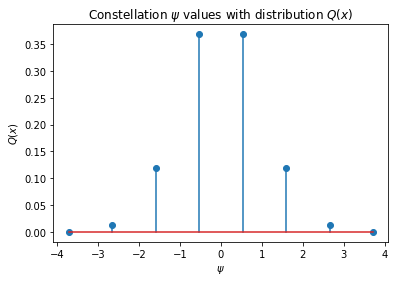

In [ ]:
const, probs, interval, energy = define_constellation(pam, lambda_dist)

#$P_{\textrm{e}}(n,M)$ bounds

In [ ]:
rcu, gallager_values = rcu_gallager_computation(rate_values, sigma_values, n, rate)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Solving saddlepoint rho for every rate value:


IntProgress(value=0, max=25)

Solving rcu bound over rate values:


IntProgress(value=0, max=25)

Solving gallager bound over rate values:


IntProgress(value=0, max=25)

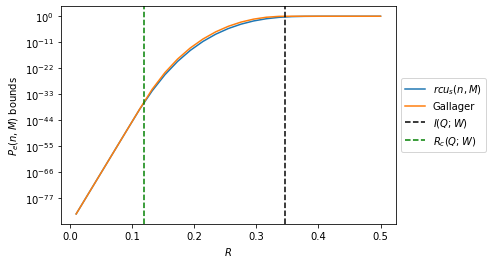

In [ ]:
plot_results()